Josh Sowers; DSC540 Advanced Machine Learning; Final Project

The goal of this project is to predict house prices in California using both textual and image features. The original dataset was retrieved from GitHub (https://github.com/emanhamed/Houses-dataset). {1} I have added an additional file that contains information from the ACS 2016 5 year estimates for zipcodes. In this notebook in particular, I focus on loading, preprocessing, and train/test splits of both the textual and the image data. This is followed by initial building of a dense neural network trained on the textual features to predict house prices. Following this, a multi-input convolution neural network is used to predict house prices as well. These models are then combined into a multi-modal neural network with fusion at different points in the convolution networks. Finally, performance is compared across the different neural network types to predict housing prices. These results are then compared to traditional machine learning algorithms that were used by the code in "House_Prices.py".

{1}: H. Ahmed E. and Moustafa M. (2016). House Price Estimation from Visual and Textual Features.In Proceedings of the 8th International Joint Conference on Computational Intelligence (IJCCI 2016)ISBN 978-989-758-201-1, pages 62-68. DOI: 10.5220/0006040700620068

# Loading and Preprocessing

## Loading the Data



In [175]:
!git clone https://github.com/JoshSowers/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 2178 (delta 6), reused 0 (delta 0), pack-reused 2166
Receiving objects: 100% (2178/2178), 176.33 MiB | 662.00 KiB/s, done.
Resolving deltas: 100% (26/26), done.


In [176]:
import os
os.getcwd()

'/content/Houses-dataset/Houses Dataset'

In [0]:
os.chdir('/content/Houses-dataset/Houses Dataset')

In [178]:
!ls | head

100_bathroom.jpg
100_bedroom.jpg
100_frontal.jpg
100_kitchen.jpg
101_bathroom.jpg
101_bedroom.jpg
101_frontal.jpg
101_kitchen.jpg
102_bathroom.jpg
102_bedroom.jpg


In [0]:
import pandas as pd
housesdf = pd.read_csv(r'HousesInfo.txt', sep=' ',header=None, names=['bedrooms', 'bathrooms', 'sqft', 'zipcode', 'price'])
zipcode_lookup = pd.read_excel(r'Zipcode Demos.xlsx')

In [180]:
housesdf.head()

,bedrooms,bathrooms,sqft,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [181]:
zipcode_lookup.head()

,Zipcode,Total Population,% male,% female,Median Age,% Latinx,% White,% Black,% American Indian,% Asian,No HS,HS or higher,Bachelors or higher,Median Income,Mean Income
0,81524,1985,0.493,0.507,46.8,0.132,0.816,0.000,0.014,0.019,0.172,0.828,0.223,68125,121985
1,85255,40151,0.490,0.510,48.0,0.051,0.865,0.007,0.004,0.054,0.023,0.977,0.667,118618,168315
2,85266,11715,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513,151134
3,91901,18586,0.486,0.514,43.5,0.173,0.758,0.014,0.013,0.018,0.089,0.911,0.291,81603,97782
4,92021,69552,0.504,0.496,35.2,0.284,0.584,0.048,0.003,0.025,0.156,0.844,0.174,48569,65900


In [0]:
zipcode_lookup = zipcode_lookup.rename(columns={'Zipcode':'zipcode'})

In [0]:
combined = housesdf.merge(zipcode_lookup, on='zipcode', how='left')

In [184]:
combined.head()

,bedrooms,bathrooms,sqft,zipcode,price,Total Population,% male,% female,Median Age,% Latinx,% White,% Black,% American Indian,% Asian,No HS,HS or higher,Bachelors or higher,Median Income,Mean Income
0,4,4.0,4053,85255,869500,40151.0,0.490,0.510,48.0,0.051,0.865,0.007,0.004,0.054,0.023,0.977,0.667,118618.0,168315.0
1,4,3.0,3343,36372,865200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,4.0,3923,85266,889000,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0
3,5,5.0,4022,85262,910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,4.0,4116,85266,971226,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0


## Preprocessing Dataframe

In [185]:
#first just look at the spread of our data. As I did not add zip code data for some zip codes, we have weird spreads
combined.describe()

,bedrooms,bathrooms,sqft,zipcode,price,Total Population,% male,% female,Median Age,% Latinx,% White,% Black,% American Indian,% Asian,No HS,HS or higher,Bachelors or higher,Median Income,Mean Income
count,535.000000,535.000000,535.000000,535.000000,5.350000e+02,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000
mean,3.377570,2.664953,2364.904673,90937.768224,5.893628e+05,31524.450216,0.494091,0.505909,42.636797,0.306037,0.546126,0.039686,0.003784,0.074398,0.129429,0.870571,0.300355,75058.196970,93473.166667
std,1.160952,0.995077,1224.556982,7141.857452,5.090261e+05,24829.804108,0.014353,0.014353,5.769437,0.179453,0.202459,0.051846,0.003891,0.095411,0.058003,0.058003,0.139464,22432.980503,28956.739044
min,1.000000,1.000000,701.000000,36372.000000,2.200000e+04,1985.000000,0.480000,0.473000,32.300000,0.036000,0.241000,0.000000,0.000000,0.008000,0.018000,0.780000,0.135000,43308.000000,52717.000000
25%,3.000000,2.000000,1440.000000,92276.000000,2.492000e+05,7803.000000,0.485000,0.506000,40.000000,0.173000,0.369000,0.017000,0.002000,0.010000,0.099000,0.828000,0.174000,48569.000000,65900.000000
50%,3.000000,2.500000,2078.000000,92880.000000,5.290000e+05,18586.000000,0.491000,0.509000,43.500000,0.258000,0.632000,0.018000,0.002000,0.016000,0.122000,0.878000,0.275000,76787.000000,101659.000000
75%,4.000000,3.000000,3067.500000,93510.000000,7.285000e+05,63228.000000,0.494000,0.515000,45.900000,0.403000,0.753000,0.048000,0.003000,0.091000,0.172000,0.901000,0.325000,91196.000000,107668.000000
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06,69552.000000,0.527000,0.520000,58.000000,0.600000,0.889000,0.244000,0.017000,0.276000,0.220000,0.982000,0.667000,118618.000000,168315.000000


### Zipcode Preprocessing

In [186]:
#get value counts to look at zip code distribution as this is a categorical variable and not continuous
combined['zipcode'].value_counts()

92276    100
93510     60
93446     54
92880     49
94501     41
91901     32
92677     26
94531     22
85255     12
96019     12
93111     11
92021     11
85266     11
81524     11
95220     10
92802      9
85262      9
62234      7
62214      4
98021      4
85377      3
60002      3
91752      3
81418      2
62025      2
92692      2
92253      2
60016      2
93924      1
90211      1
90038      1
93314      1
90265      1
93105      1
92040      1
62249      1
95008      1
91915      1
62034      1
85331      1
94565      1
94568      1
92543      1
60046      1
62088      1
81521      1
36372      1
93720      1
90803      1
Name: zipcode, dtype: int64

So we can see that the zipcode distribution is quite unbalanced. Due to this, there was an arbitrary cutoff selected, where 10 houses in that zipcode were kept. The following cells do this.

In [0]:
#get the counts and the zip codes as lists.
zips = combined['zipcode'].value_counts().keys().tolist()
counts = combined['zipcode'].value_counts().tolist()

In [0]:
clean_combined = combined                                  #copying dataset to drop values out of
for (code, count) in zip(zips,counts):                    #iterate over lists
  if count < 10:                                          #arbitrary cutoff
    idxs = combined[combined['zipcode']==code].index      #get index if less than 10
    clean_combined.drop(idxs, inplace=True)                #drop in place

In [189]:
 clean_combined['zipcode'].value_counts()                  #check value counts

92276    100
93510     60
93446     54
92880     49
94501     41
91901     32
92677     26
94531     22
96019     12
85255     12
93111     11
92021     11
85266     11
81524     11
95220     10
Name: zipcode, dtype: int64

In [190]:
#note that I do not reset the index. This is crucial as we are going to feed our images in and need that index to match the correct houses
clean_combined.head()

,bedrooms,bathrooms,sqft,zipcode,price,Total Population,% male,% female,Median Age,% Latinx,% White,% Black,% American Indian,% Asian,No HS,HS or higher,Bachelors or higher,Median Income,Mean Income
0,4,4.0,4053,85255,869500,40151.0,0.490,0.510,48.0,0.051,0.865,0.007,0.004,0.054,0.023,0.977,0.667,118618.0,168315.0
2,3,4.0,3923,85266,889000,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0
4,3,4.0,4116,85266,971226,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0
5,4,5.0,4581,85266,1249000,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0
7,4,5.0,5524,85266,1698000,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0


So as I've split out zipcode into description features, we no longer need that column. All other values are continuous so no need for dummy variables.

In [191]:
#im lazy with naming so I want to just use final_df to feed into my networks
final_df = clean_combined.drop(columns=['zipcode'])
final_df.head()

,bedrooms,bathrooms,sqft,price,Total Population,% male,% female,Median Age,% Latinx,% White,% Black,% American Indian,% Asian,No HS,HS or higher,Bachelors or higher,Median Income,Mean Income
0,4,4.0,4053,869500,40151.0,0.490,0.510,48.0,0.051,0.865,0.007,0.004,0.054,0.023,0.977,0.667,118618.0,168315.0
2,3,4.0,3923,889000,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0
4,3,4.0,4116,971226,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0
5,4,5.0,4581,1249000,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0
7,4,5.0,5524,1698000,11715.0,0.493,0.507,58.0,0.036,0.889,0.013,0.000,0.037,0.018,0.982,0.622,114513.0,151134.0


### Distributions and Normalization

We are most interested in our target variable, price. As the zipcode features are more categorical due to the nature of zipcodes being categorical, normalizing these will be more difficult, if possible at all.

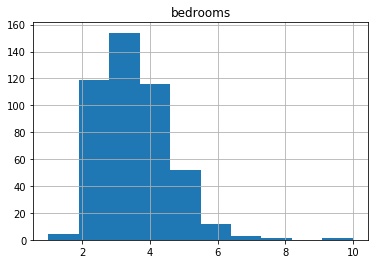

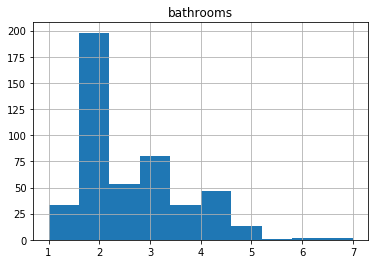

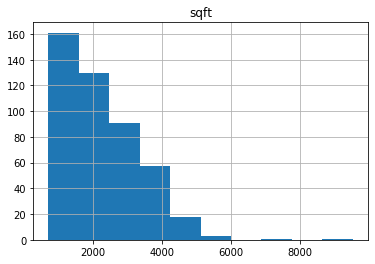

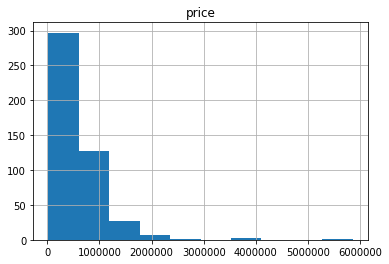

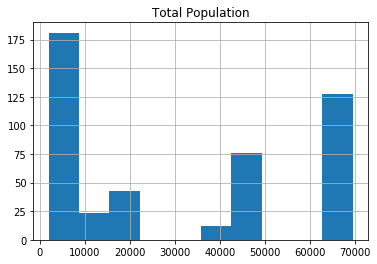

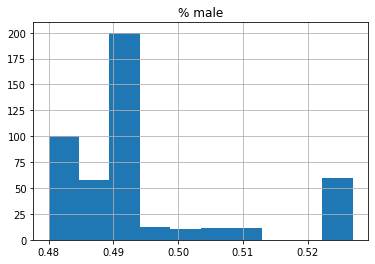

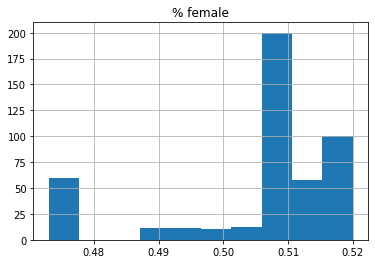

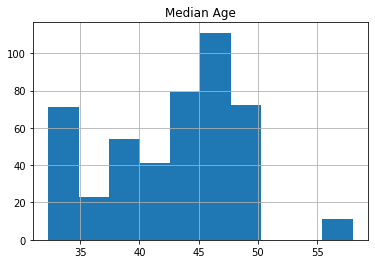

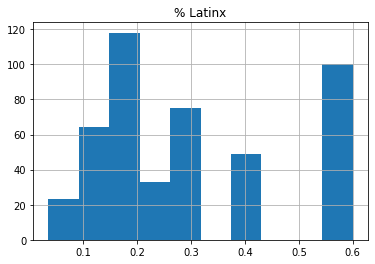

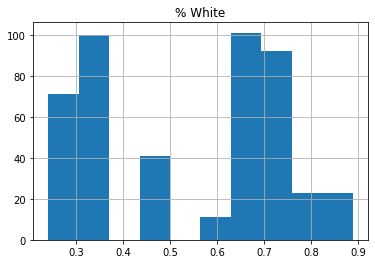

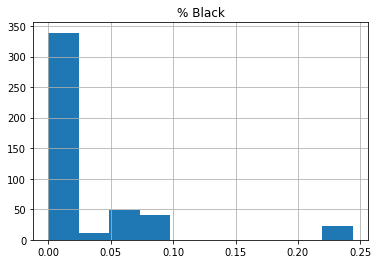

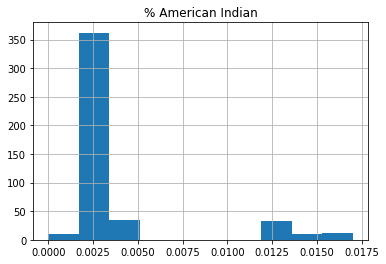

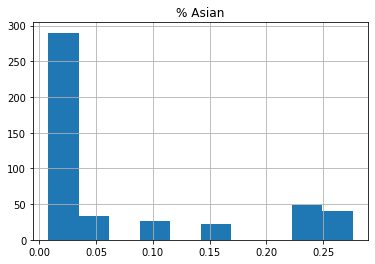

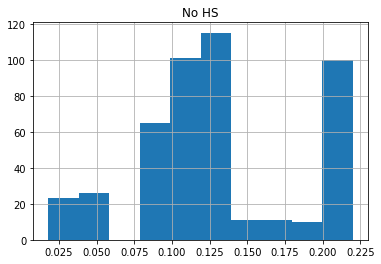

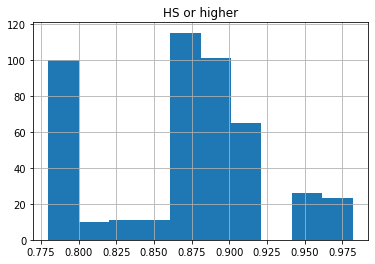

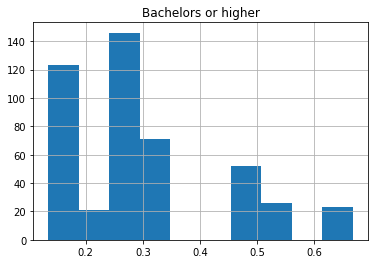

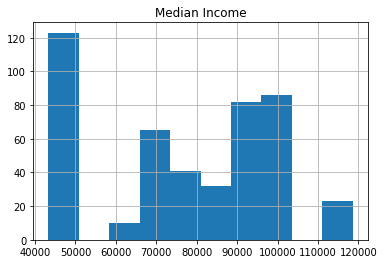

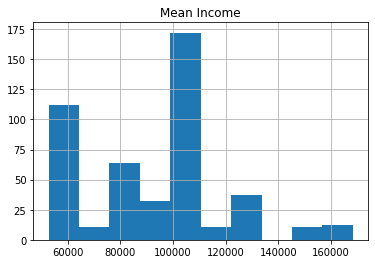

In [192]:
import matplotlib.pyplot as plt
for col in final_df.columns:
  final_df.hist(column=col)

(array([297., 127.,  27.,   7.,   1.,   0.,   2.,   0.,   0.,   1.]),
 array([-1.08900893,  0.04379195,  1.17659284,  2.30939373,  3.44219461,
         4.5749955 ,  5.70779638,  6.84059727,  7.97339816,  9.10619904,
        10.23899993]),
 <a list of 10 Patch objects>)

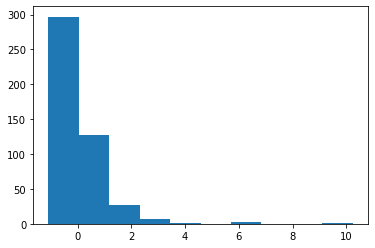

In [193]:
#Z score normalization for outlier detection in our target variable
from sklearn.preprocessing import StandardScaler
import numpy as np
outlier_df = final_df
price = np.array(outlier_df['price']).reshape(-1, 1)
scaler = StandardScaler()
outliers = scaler.fit_transform(price)
plt.hist(outliers)

In [194]:
sorted(outliers)

[array([-1.08900893]),
 array([-1.06183414]),
 array([-1.04844084]),
 array([-1.03485344]),
 array([-1.03465934]),
 array([-1.01544287]),
 array([-1.01330771]),
 array([-1.01039612]),
 array([-1.00845507]),
 array([-1.00554348]),
 array([-1.00166137]),
 array([-1.00069084]),
 array([-0.99991442]),
 array([-0.99991442]),
 array([-0.99874978]),
 array([-0.99680872]),
 array([-0.99680872]),
 array([-0.99622641]),
 array([-0.9960323]),
 array([-0.9960323]),
 array([-0.9960323]),
 array([-0.99195608]),
 array([-0.98632702]),
 array([-0.98632702]),
 array([-0.9822508]),
 array([-0.97739815]),
 array([-0.97662173]),
 array([-0.97662173]),
 array([-0.97662173]),
 array([-0.9688575]),
 array([-0.96691645]),
 array([-0.96691645]),
 array([-0.96691645]),
 array([-0.9618697]),
 array([-0.95798758]),
 array([-0.94750588]),
 array([-0.94440018]),
 array([-0.94362376]),
 array([-0.94342966]),
 array([-0.94245913]),
 array([-0.94245913]),
 array([-0.9414886]),
 array([-0.93974165]),
 array([-0.9395475

Based on the output, six houses are outside of the range (-3,3). This equates to a price > $2m

In [0]:
#removing the outlier prices
outlier_price_drops = final_df[final_df['price']>2000000].index.to_list()
final_df.drop(outlier_price_drops, inplace=True)

In [196]:
#check to make sure it worked and no rows mean we are good
final_df[final_df['price']>2000000]

,bedrooms,bathrooms,sqft,price,Total Population,% male,% female,Median Age,% Latinx,% White,% Black,% American Indian,% Asian,No HS,HS or higher,Bachelors or higher,Median Income,Mean Income


In [0]:
from google.colab import files

final_df.to_csv('final_df.csv')
files.download('final_df.csv')

In [0]:
#So in order to ease interpretation, I am not scaling price, but am scaling every other variable between 0-1. 
#Due to the % already being between 0-1, they also do not need to be scaled
target = final_df['price']
final_df.drop(columns='price', inplace=True)

In [0]:
#use sklearn to scale every column between 0,1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
final_df_scaled = final_df
final_df_scaled = \
    pd.DataFrame(scaler.fit_transform(final_df_scaled), columns=final_df_scaled.columns)

In [69]:
final_df_scaled.head()

,bedrooms,bathrooms,sqft,Total Population,% male,% female,Median Age,% Latinx,% White,% Black,% American Indian,% Asian,No HS,HS or higher,Bachelors or higher,Median Income,Mean Income
0,0.333333,0.500000,0.379400,0.564862,0.212766,0.787234,0.610895,0.026596,0.962963,0.028689,0.235294,0.171642,0.024752,0.975248,1.000000,1.000000,1.000000
1,0.222222,0.500000,0.364686,0.144005,0.276596,0.723404,1.000000,0.000000,1.000000,0.053279,0.000000,0.108209,0.000000,1.000000,0.915414,0.945492,0.851373
2,0.222222,0.500000,0.386531,0.144005,0.276596,0.723404,1.000000,0.000000,1.000000,0.053279,0.000000,0.108209,0.000000,1.000000,0.915414,0.945492,0.851373
3,0.333333,0.666667,0.439162,0.144005,0.276596,0.723404,1.000000,0.000000,1.000000,0.053279,0.000000,0.108209,0.000000,1.000000,0.915414,0.945492,0.851373
4,0.333333,0.666667,0.545897,0.144005,0.276596,0.723404,1.000000,0.000000,1.000000,0.053279,0.000000,0.108209,0.000000,1.000000,0.915414,0.945492,0.851373


## Loading Images

Here we will load the images using the indexes from our dataframe. It is crucial to use the indexes as the pictures will then load in order. We can then add each set to a list to feed into our network.

In [0]:
import glob as g
import cv2
images = []      
heights = []
widths = []
inputPath = os.getcwd()
#loop over the indexes of the houses that we kept from the last section
#find the four images for the house and sort the file paths, ensuring the four are always in the *same order*
for i in final_df.index.values:                                                            
  basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])                           
  housePath = sorted(list(g.glob(basePath)))
  for house in housePath:
    image=cv2.imread(house)
    height, width = image.shape[0], image.shape[1]
    heights.append(height)
    widths.append(width)
    images.append(image)

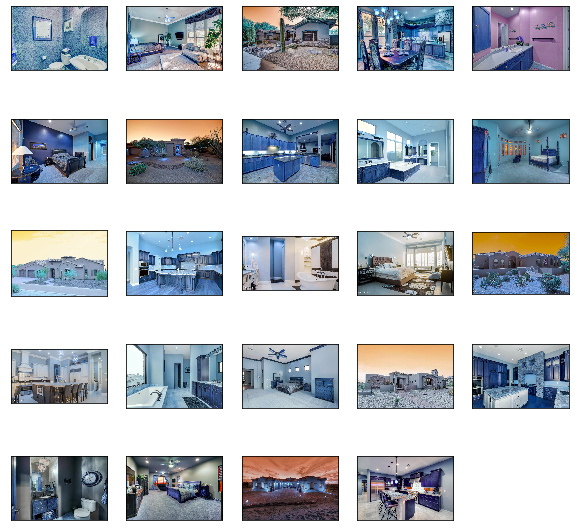

In [27]:
#We want to see some of the images
import matplotlib.image as mpimg
plt.figure(figsize=(10,10))
for i in range(24):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
plt.show()

In [28]:
print('Min Height: {}, Min Width: {}'.format(min(heights), min(widths)))

Min Height: 187, Min Width: 240


So since we know that the minimum height is 187 and width is 240, we will resize all images to (160,160) and normalize pixel values between 0-1


In [0]:
#resizing images, scaling 0-1, and adding to final image list. Again, these are in order per index
final_imgs = []
for img in images:
  img = cv2.resize(img, (160,160))
  img = img/255
  final_imgs.append(img)

Remember, four images per house. So it looks like we have bathrooms first, followed by bedrooms, curb view, and kitchens. As we are using a four image input network, we need to get each of these into a list so that we can feed it into the network correctly. We are also going to normalize images.

In [30]:
#check to see that this is divisible by 4 and matches the length of our dataframe...Perfect
len(final_imgs)/4 == len(final_df)

True

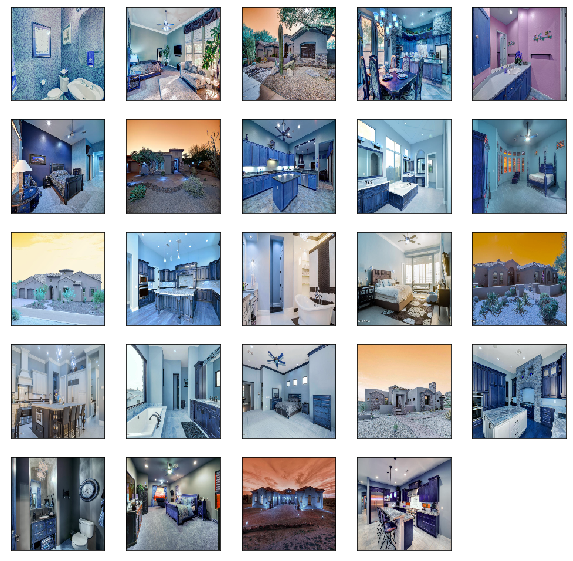

In [31]:
#check to see same size
plt.figure(figsize=(10,10))
for i in range(24):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(final_imgs[i])
plt.show()

In [0]:
#Here we will create the individual lists for the images, otherwise the splitting will mess up the ordering of the 4
bathrooms, bedrooms, curbs, kitchens = [],[],[],[] 
for i in range(int(len(final_imgs)/4)):
  if i == 0:
    bathrooms.append(final_imgs[i])
    bedrooms.append(final_imgs[i+1])
    curbs.append(final_imgs[i+2])
    kitchens.append(final_imgs[i+3])
  else:
    bathrooms.append(final_imgs[i*4])
    bedrooms.append(final_imgs[(i*4)+1])
    curbs.append(final_imgs[(i*4)+2])
    kitchens.append(final_imgs[(i*4)+3])    

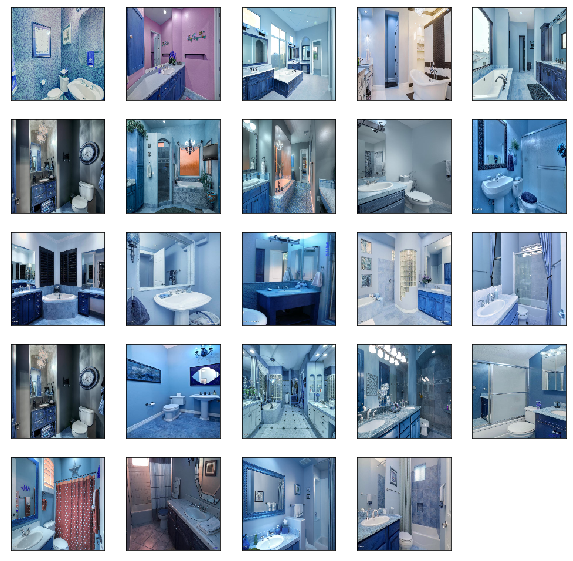

456 456 456 456


In [33]:
#just check to see that we get bathrooms only
plt.figure(figsize=(10,10))
for i in range(24):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(bathrooms[i])
plt.show()
print(len(bathrooms), len(bedrooms), len(curbs), len(kitchens))

So we have the individual lists for the images, but we can also create one image per house and maintain the correct image size (160,160). That means we will have to resize the images again but that is easy enough.

In [0]:
smaller_imgs = []
for img in images:
  img = cv2.resize(img, (80,80))
  img = img/255
  smaller_imgs.append(img)

In [0]:
#Here we are going to combine the images for the houses. In this way, we will have one image per house
combined_imgs = []
for i in range(int(len(smaller_imgs)/4)):
  out_img = np.zeros((160,160,3))
  if i == 0:
    out_img[0:80,0:80] = smaller_imgs[i]
    out_img[0:80,80:160] = smaller_imgs[i+1]
    out_img[80:160,0:80] = smaller_imgs[i+2]
    out_img[80:160,80:160] = smaller_imgs[i+3]
  else:
    out_img[0:80,0:80] = smaller_imgs[i*4]
    out_img[0:80,80:160] = smaller_imgs[(i*4)+1]
    out_img[80:160,0:80] = smaller_imgs[(i*4)+2]
    out_img[80:160,80:160] = smaller_imgs[(i*4)+3]

  combined_imgs.append(out_img)   

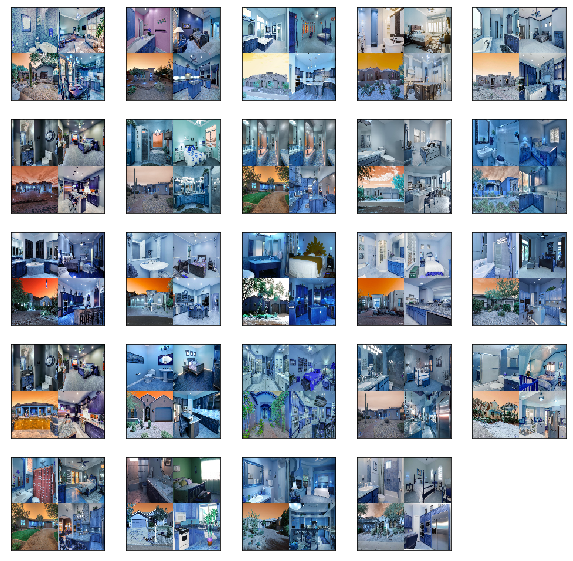

In [36]:
#just check to see that we get tiled images
plt.figure(figsize=(10,10))
for i in range(24):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(combined_imgs[i])
plt.show()

# Final Checks and Train-Test Split

In [70]:
#now that we loaded the images, we can reset our index to iterate correctly
final_df_scaled.reset_index(drop=True, inplace=True)
final_df_scaled.head()

,bedrooms,bathrooms,sqft,Total Population,% male,% female,Median Age,% Latinx,% White,% Black,% American Indian,% Asian,No HS,HS or higher,Bachelors or higher,Median Income,Mean Income
0,0.333333,0.500000,0.379400,0.564862,0.212766,0.787234,0.610895,0.026596,0.962963,0.028689,0.235294,0.171642,0.024752,0.975248,1.000000,1.000000,1.000000
1,0.222222,0.500000,0.364686,0.144005,0.276596,0.723404,1.000000,0.000000,1.000000,0.053279,0.000000,0.108209,0.000000,1.000000,0.915414,0.945492,0.851373
2,0.222222,0.500000,0.386531,0.144005,0.276596,0.723404,1.000000,0.000000,1.000000,0.053279,0.000000,0.108209,0.000000,1.000000,0.915414,0.945492,0.851373
3,0.333333,0.666667,0.439162,0.144005,0.276596,0.723404,1.000000,0.000000,1.000000,0.053279,0.000000,0.108209,0.000000,1.000000,0.915414,0.945492,0.851373
4,0.333333,0.666667,0.545897,0.144005,0.276596,0.723404,1.000000,0.000000,1.000000,0.053279,0.000000,0.108209,0.000000,1.000000,0.915414,0.945492,0.851373


In [72]:
target.head()

0     869500
2     889000
4     971226
5    1249000
7    1698000
Name: price, dtype: int64

In [0]:
#Train test split. We NEED to set the random state so all sets split evenly
from sklearn.model_selection import train_test_split
(att_tr, att_ts, bath_tr, bath_ts, bed_tr, bed_ts, curb_tr, curb_ts, kit_tr, kit_ts, com_tr, com_ts, target_tr, target_ts)\
   = train_test_split(final_df_scaled, bathrooms, bedrooms, curbs, kitchens, combined_imgs, target, test_size=0.2,random_state=42, shuffle=True)

# Model Building

In this section, I focus on building models using keras Functional API. Multiple different points of fusion will be used to see the different effects of fusing the input images at different points.

In [40]:
#import statements
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, Dropout, BatchNormalization, concatenate
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [0]:
#keras doesnt natively have RMSE 
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [0]:
import matplotlib as mpl
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
def plot_model(model, name):
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('{} Model loss'.format(name))
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

In [0]:
epochs = 125

## Image Lists

### Images Only

In [0]:
def create_image_model():
  input_shape = (160,160,3)
  in1 = Input(shape=(input_shape))
  conv1a = Conv2D(64, (2,2), activation='relu')(in1)
  max1a = MaxPool2D()(conv1a)
  conv1b = Conv2D(64, (2,2), activation='relu')(max1a)
  max1b = MaxPool2D()(conv1b)
  batch1 = BatchNormalization()(max1b)
  out1 = Dropout(0.5)(batch1)

  in2 = Input(shape=(input_shape))
  conv2a = Conv2D(64, (2,2), activation='relu')(in2)
  max2a = MaxPool2D()(conv2a)
  conv2b = Conv2D(64, (2,2), activation='relu')(max2a)
  max2b = MaxPool2D()(conv2b)
  batch2 = BatchNormalization()(max2b)
  out2 = Dropout(0.5)(batch2)

  in3 = Input(shape=(input_shape))
  conv3a = Conv2D(64, (2,2), activation='relu')(in3)
  max3a = MaxPool2D()(conv3a)
  conv3b = Conv2D(64, (2,2), activation='relu')(max3a)
  max3b = MaxPool2D()(conv3b)
  batch3 = BatchNormalization()(max3b)
  out3 = Dropout(0.5)(batch3)

  in4 = Input(shape=(input_shape))
  conv4a = Conv2D(64, (2,2), activation='relu')(in4)
  max4a = MaxPool2D()(conv4a)
  conv4b = Conv2D(64, (2,2), activation='relu')(max4a)
  max4c = MaxPool2D()(conv4b)
  batch4 = BatchNormalization()(max4c)
  out4 = Dropout(0.5)(batch4)

  x = concatenate([out1, out2, out3, out4])
  x = Flatten()(x)
  dense1 = Dense(256, activation='relu')(x)
  drop_out = Dropout(0.4)(dense1)
  out_layer = Dense(1, activation='linear')(drop_out)

  model = Model(inputs=[in1,in2,in3,in4], outputs=out_layer)
  model.compile(optimizer='adam', loss=rmse, metrics=[rmse])
  return model

In [45]:
model = create_image_model()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [46]:
image_model = model.fit(x=[bath_tr, bed_tr, curb_tr, kit_tr], y=target_tr, validation_data=[[bath_ts, bed_ts, curb_ts, kit_ts], target_ts],
                        epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 364 samples, validate on 92 samples
Epoch 1/125
364/364 [==============================] - 13s 36ms/step - loss: 543995.1724 - rmse: 543995.1724 - val_loss: 541985.6821 - val_rmse: 541985.6821
Epoch 2/125
364/364 [==============================] - 3s 8ms/step - loss: 535497.4231 - rmse: 535497.4231 - val_loss: 528408.9307 - val_rmse: 528408.9307
Epoch 3/125
364/364 [==============================] - 3s 8ms/step - loss: 517824.6374 - rmse: 517824.6374 - val_loss: 509265.3261 - val_rmse: 509265.3261
Epoch 4/125
364/364 [==============================] - 3s 8ms/step - loss: 489621.2806 - rmse: 489621.2806 - val_loss: 479739.3465 - val_rmse: 479739.3465
Epoch 5/125
364/364 [==============================] - 3s 8ms/step - loss: 451207.9440 - rmse: 451207.9440 - val_loss: 437210.0476 - val_rmse: 437210.0476
Epoch 6/125
364/364 [==============================] - 3s 8ms/step - loss: 411193.

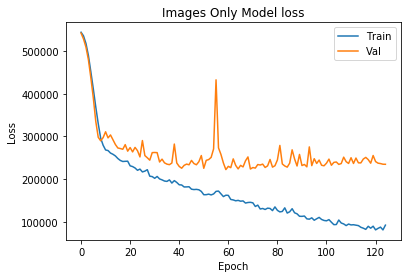

In [51]:
plot_model(image_model, 'Images Only')

### Dense Model

In [0]:
def create_dense_model():
  in_dense = Input(shape=(17,))
  dense1a = Dense(1024, activation='relu')(in_dense)
  batch1 = BatchNormalization()(dense1a)
  drop1 = Dropout(0.3)(batch1)
  dense2a = Dense(512, activation='relu')(drop1)
  batch2 = BatchNormalization()(dense2a)
  drop2 = Dropout(0.4)(batch2)
  dense_out = Dense(128, activation='relu')(drop2)
  drop_out = Dropout(0.5)(dense_out)
  out_layer = Dense(1, activation='linear')(drop_out)

  model = Model(inputs=[in_dense], outputs=out_layer)
  optimizer = Adam(lr=0.001)
  model.compile(optimizer=optimizer, loss=rmse, metrics=[rmse])
  return model

In [0]:
model = create_dense_model()

In [76]:
dense = model.fit(x=att_tr, y=target_tr, validation_data=[att_ts, target_ts],
                        epochs=250)

Train on 364 samples, validate on 92 samples
Epoch 1/250
364/364 [==============================] - 1s 4ms/step - loss: 545528.4004 - rmse: 545528.4004 - val_loss: 547125.4864 - val_rmse: 547125.4864
Epoch 2/250
364/364 [==============================] - 0s 230us/step - loss: 545517.4863 - rmse: 545517.4863 - val_loss: 547108.8071 - val_rmse: 547108.8071
Epoch 3/250
364/364 [==============================] - 0s 221us/step - loss: 545502.2716 - rmse: 545502.2716 - val_loss: 547083.0897 - val_rmse: 547083.0897
Epoch 4/250
364/364 [==============================] - 0s 242us/step - loss: 545477.3451 - rmse: 545477.3451 - val_loss: 547037.9647 - val_rmse: 547037.9647
Epoch 5/250
364/364 [==============================] - 0s 233us/step - loss: 545433.2222 - rmse: 545433.2222 - val_loss: 546950.1087 - val_rmse: 546950.1087
Epoch 6/250
364/364 [==============================] - 0s 236us/step - loss: 545368.5845 - rmse: 545368.5845 - val_loss: 546816.7473 - val_rmse: 546816.7473
Epoch 7/250
364

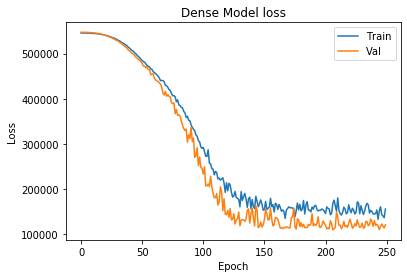

In [77]:
plot_model(dense, 'Dense')

### Combined Model

In [0]:
def create_combined_model():
  input_shape=(160,160,3)
  in1 = Input(shape=(input_shape))
  conv1a = Conv2D(64, (2,2), activation='relu')(in1)
  max1a = MaxPool2D()(conv1a)
  conv1b = Conv2D(64, (2,2), activation='relu')(max1a)
  max1b = MaxPool2D()(conv1b)
  batch1 = BatchNormalization()(max1b)
  out1 = Dropout(0.5)(batch1)

  in2 = Input(shape=(input_shape))
  conv2a = Conv2D(64, (2,2), activation='relu')(in2)
  max2a = MaxPool2D()(conv2a)
  conv2b = Conv2D(64, (2,2), activation='relu')(max2a)
  max2b = MaxPool2D()(conv2b)
  batch2 = BatchNormalization()(max2b)
  out2 = Dropout(0.5)(batch2)


  in3 = Input(shape=(input_shape))
  conv3a = Conv2D(64, (2,2), activation='relu')(in3)
  max3a = MaxPool2D()(conv3a)
  conv3b = Conv2D(64, (2,2), activation='relu')(max3a)
  max3b = MaxPool2D()(conv3b)
  batch3 = BatchNormalization()(max3b)
  out3 = Dropout(0.5)(batch3)

  in4 = Input(shape=(input_shape))
  conv4a = Conv2D(64, (2,2), activation='relu')(in4)
  max4a = MaxPool2D()(conv4a)
  conv4b = Conv2D(64, (2,2), activation='relu')(max4a)
  max4c = MaxPool2D()(conv4b)
  batch4 = BatchNormalization()(max4c)
  out4 = Dropout(0.5)(batch4)

  in_dense = Input(shape=(17,))
  dense1a = Dense(256, activation='relu')(in_dense)
  batch_dense = BatchNormalization()(dense1a)
  dense2a = Dense(256, activation='relu')(batch_dense)
  drop_dense = Dropout(0.5)(dense2a)
  dense_out = Dense(512, activation='relu')(dense2a)

  x = concatenate([out1, out2, out3, out4])
  x = Flatten()(x)
  dense1 = Dense(256, activation='relu')(x)
  
  x = concatenate([dense1, dense_out])
  dense2 = Dense(256, activation='relu')(x)
  drop_out = Dropout(0.4)(dense2)
  out_layer = Dense(1, activation='linear')(drop_out)

  model = Model(inputs=[in1,in2,in3,in4, in_dense], outputs=out_layer)
  model.compile(optimizer='adam', loss=rmse, metrics=[rmse])
  return model



In [0]:
model = create_combined_model()

In [83]:
combined = model.fit(x=[bath_tr, bed_tr, curb_tr, kit_tr, att_tr], y=target_tr, validation_data=[[bath_ts, bed_ts, curb_ts, kit_ts, att_ts], target_ts],
                        epochs=epochs)

Train on 364 samples, validate on 92 samples
Epoch 1/125
364/364 [==============================] - 7s 20ms/step - loss: 543943.4571 - rmse: 543943.4571 - val_loss: 535577.1168 - val_rmse: 535577.1168
Epoch 2/125
364/364 [==============================] - 3s 8ms/step - loss: 517780.1920 - rmse: 517780.1920 - val_loss: 438780.8505 - val_rmse: 438780.8505
Epoch 3/125
364/364 [==============================] - 3s 8ms/step - loss: 414719.5687 - rmse: 414719.5687 - val_loss: 296115.8709 - val_rmse: 296115.8709
Epoch 4/125
364/364 [==============================] - 3s 8ms/step - loss: 292240.8767 - rmse: 292240.8767 - val_loss: 316224.6168 - val_rmse: 316224.6168
Epoch 5/125
364/364 [==============================] - 3s 8ms/step - loss: 269047.1363 - rmse: 269047.1363 - val_loss: 365376.7378 - val_rmse: 365376.7378
Epoch 6/125
364/364 [==============================] - 3s 8ms/step - loss: 247558.4200 - rmse: 247558.4200 - val_loss: 283434.4742 - val_rmse: 283434.4742
Epoch 7/125
364/364 [===

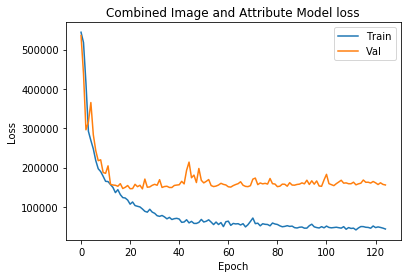

In [84]:
plot_model(combined, 'Combined Image and Attribute')

### Combined Model with instant fusion

Here I concatenate the images right away rather than at the end after they go through their own convolution layers.

In [0]:
def fusion_model():
  input_shape = (160,160,3)
  
  in1 = Input(shape=(input_shape))
  in2 = Input(shape=(input_shape))
  in3 = Input(shape=(input_shape))
  in4 = Input(shape=(input_shape))

  x = concatenate([in1, in2, in3, in4])

  conv1a = Conv2D(64, (2,2), activation='relu')(x)
  max1a = MaxPool2D()(conv1a)
  conv1b = Conv2D(64, (2,2), activation='relu')(max1a)
  batch1 = BatchNormalization()(conv1b)
  max1b = MaxPool2D()(batch1)
  conv1c = Conv2D(32, (1,1), activation='relu')(max1b)
  batch2 = BatchNormalization()(conv1c)
  max1c = MaxPool2D()(batch2)
  out1 = Dropout(0.5)(max1c)
  x = Flatten()(out1)

  in_dense = Input(shape=(17,))
  dense1a = Dense(128, activation='relu')(in_dense)
  batch_dense = BatchNormalization()(dense1a)
  dense2a = Dense(128, activation='relu')(batch_dense)
  drop_dense = Dropout(0.5)(dense2a)
  dense_out = Dense(64, activation='relu')(dense2a)

  x = concatenate([x, dense_out])
  dense2 = Dense(64, activation='relu')(x)
  dense3 = Dense(64, activation='relu')(dense2)
  drop_out = Dropout(0.4)(dense3)
  out_layer = Dense(1, activation='linear')(drop_out)

  model = Model(inputs=[in1,in2,in3,in4, in_dense], outputs=out_layer)
  optimizer = Adam(lr=0.001)
  model.compile(optimizer=optimizer, loss='mae', metrics=[rmse])
  return model

In [0]:
model = fusion_model()

In [95]:
fusion = model.fit(x=[bath_tr, bed_tr, curb_tr, kit_tr, att_tr], y=target_tr, validation_data=[[bath_ts, bed_ts, curb_ts, kit_ts, att_ts], target_ts],
                        epochs=epochs)

Train on 364 samples, validate on 92 samples
Epoch 1/125
364/364 [==============================] - 4s 11ms/step - loss: 545461.7030 - rmse: 545461.7030 - val_loss: 546917.3315 - val_rmse: 546917.3315
Epoch 2/125
364/364 [==============================] - 1s 3ms/step - loss: 544996.7150 - rmse: 544996.7150 - val_loss: 546024.4592 - val_rmse: 546024.4592
Epoch 3/125
364/364 [==============================] - 1s 3ms/step - loss: 543803.0151 - rmse: 543803.0151 - val_loss: 543457.3125 - val_rmse: 543457.3125
Epoch 4/125
364/364 [==============================] - 1s 3ms/step - loss: 541296.4499 - rmse: 541296.4499 - val_loss: 538434.6929 - val_rmse: 538434.6929
Epoch 5/125
364/364 [==============================] - 1s 3ms/step - loss: 536206.0275 - rmse: 536206.0275 - val_loss: 527406.0367 - val_rmse: 527406.0367
Epoch 6/125
364/364 [==============================] - 1s 3ms/step - loss: 526941.6178 - rmse: 526941.6178 - val_loss: 506635.3084 - val_rmse: 506635.3084
Epoch 7/125
364/364 [===

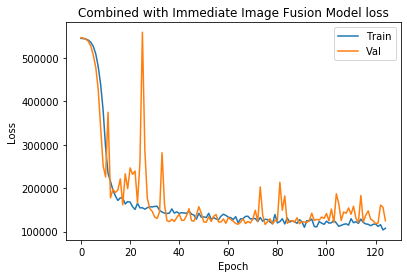

In [97]:
plot_model(fusion, 'Combined with Immediate Image Fusion')

## Combined Image Models

### Images Only

In [0]:
def create_tileimage_model():
  input_shape = (160,160,3)
  
  in1 = Input(shape=(input_shape))

  conv1a = Conv2D(64, (2,2), activation='relu')(in1)
  max1a = MaxPool2D()(conv1a)
  conv1b = Conv2D(64, (2,2), activation='relu')(max1a)
  batch1 = BatchNormalization()(conv1b)
  max1b = MaxPool2D()(batch1)
  conv1c = Conv2D(32, (1,1), activation='relu')(max1b)
  batch2 = BatchNormalization()(conv1c)
  max1c = MaxPool2D()(batch2)
  out1 = Dropout(0.5)(max1c)
  x = Flatten()(out1)  

  dense1 = Dense(256, activation='relu')(x)
  batch3 = BatchNormalization()(dense1)
  drop_out = Dropout(0.4)(batch3)
  dense2 = Dense(128, activation='relu')(drop_out)
  batch4 = BatchNormalization()(dense2)
  drop_out2 = Dropout(0.4)(batch4)
  out_layer = Dense(1, activation='linear')(drop_out2)

  model = Model(inputs=in1, outputs=out_layer)
  optimizer = Adam(lr=0.01)
  model.compile(optimizer=optimizer, loss=rmse, metrics=[rmse])
  return model

In [0]:
model = create_tileimage_model()

In [130]:
tile_image = model.fit(x=[com_tr], y = target_tr, validation_data=[[com_ts], target_ts], epochs=1000)

Train on 364 samples, validate on 92 samples
Epoch 1/1000
364/364 [==============================] - 5s 14ms/step - loss: 545532.8633 - rmse: 545532.8633 - val_loss: 547146.3152 - val_rmse: 547146.3152
Epoch 2/1000
364/364 [==============================] - 1s 2ms/step - loss: 545529.7445 - rmse: 545529.7445 - val_loss: 547144.8016 - val_rmse: 547144.8016
Epoch 3/1000
364/364 [==============================] - 1s 2ms/step - loss: 545523.4265 - rmse: 545523.4265 - val_loss: 547111.3614 - val_rmse: 547111.3614
Epoch 4/1000
364/364 [==============================] - 1s 2ms/step - loss: 545511.7692 - rmse: 545511.7692 - val_loss: 547079.7989 - val_rmse: 547079.7989
Epoch 5/1000
364/364 [==============================] - 1s 2ms/step - loss: 545491.5364 - rmse: 545491.5364 - val_loss: 547057.9647 - val_rmse: 547057.9647
Epoch 6/1000
364/364 [==============================] - 1s 2ms/step - loss: 545462.9440 - rmse: 545462.9440 - val_loss: 546936.6576 - val_rmse: 546936.6576
Epoch 7/1000
364/3

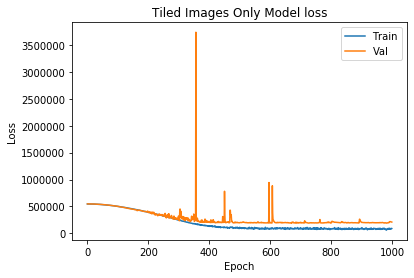

In [131]:
plot_model(tile_image, 'Tiled Images Only')

### Combined Images and Attributes

In [0]:
def combined_image_model():
  input_shape = (160,160,3)
  
  in1 = Input(shape=(input_shape))

  conv1a = Conv2D(64, (2,2), activation='relu')(in1)
  max1a = MaxPool2D()(conv1a)
  conv1b = Conv2D(64, (2,2), activation='relu')(max1a)
  batch1 = BatchNormalization()(conv1b)
  max1b = MaxPool2D()(batch1)
  conv1c = Conv2D(32, (1,1), activation='relu')(max1b)
  batch2 = BatchNormalization()(conv1c)
  max1c = MaxPool2D()(batch2)
  out1 = Dropout(0.5)(max1c)
  x = Flatten()(out1)  

  in_dense = Input(shape=(17,))
  dense1a = Dense(128, activation='relu')(in_dense)
  batch_dense = BatchNormalization()(dense1a)
  dense2a = Dense(128, activation='relu')(batch_dense)
  drop_dense = Dropout(0.5)(dense2a)
  dense_out = Dense(64, activation='relu')(dense2a)

  x = concatenate([x, dense_out])
  dense2 = Dense(64, activation='relu')(x)
  dense3 = Dense(64, activation='relu')(dense2)
  drop_out = Dropout(0.4)(dense3)
  out_layer = Dense(1, activation='linear')(drop_out)

  model = Model(inputs=[in1, in_dense], outputs=out_layer)
  optimizer = Adam(lr=0.001)
  model.compile(optimizer=optimizer, loss='mae', metrics=[rmse])
  return model

In [0]:
model = combined_image_model()

In [107]:
combined3 = model.fit(x=[com_tr, att_tr], y=target_tr, validation_data=[[com_ts, att_ts], target_ts],
                        epochs=epochs, batch_size=32)

Train on 364 samples, validate on 92 samples
Epoch 1/125
364/364 [==============================] - 4s 10ms/step - loss: 545457.5958 - rmse: 545457.5958 - val_loss: 546850.5380 - val_rmse: 546850.5380
Epoch 2/125
364/364 [==============================] - 1s 2ms/step - loss: 545071.2613 - rmse: 545071.2613 - val_loss: 545987.4973 - val_rmse: 545987.4973
Epoch 3/125
364/364 [==============================] - 1s 2ms/step - loss: 544059.3073 - rmse: 544059.3073 - val_loss: 544165.3098 - val_rmse: 544165.3098
Epoch 4/125
364/364 [==============================] - 1s 2ms/step - loss: 541805.8709 - rmse: 541805.8709 - val_loss: 538770.2364 - val_rmse: 538770.2364
Epoch 5/125
364/364 [==============================] - 1s 2ms/step - loss: 537143.7696 - rmse: 537143.7696 - val_loss: 529425.0829 - val_rmse: 529425.0829
Epoch 6/125
364/364 [==============================] - 1s 2ms/step - loss: 528386.7589 - rmse: 528386.7589 - val_loss: 514399.2853 - val_rmse: 514399.2853
Epoch 7/125
364/364 [===

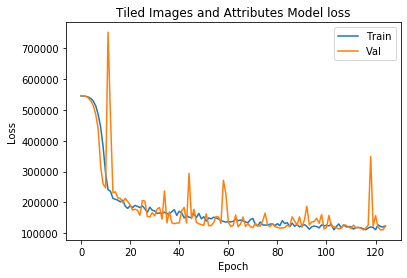

In [108]:
plot_model(combined3, 'Tiled Images and Attributes')

## Transfer Learning Model

Here I import VGG-19 and explore using ImageNet weights in order to see if my previous image results are an effect of not having a model trained for a long enough period of time.

### VGG-19 Tiled Images

In [0]:
from keras.applications.vgg19 import VGG19
from keras.layers import GlobalAveragePooling2D
def transfer_model():
  base_model = VGG19(weights='imagenet', include_top=False, input_shape=(160,160,3))
  for layer in base_model.layers:
    layer.trainable = True
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  dense2 = Dense(64, activation='relu')(x)
  dense3 = Dense(64, activation='relu')(dense2)
  drop_out = Dropout(0.4)(dense3)
  out_layer = Dense(1, activation='linear')(drop_out)

  model = Model(inputs=base_model.input, outputs=out_layer)
  optimizer = Adam(lr=0.001)
  model.compile(optimizer=optimizer, loss='mae', metrics=[rmse])
  return model

In [0]:
model = transfer_model()

In [150]:
transfer = model.fit(x=[com_tr], y=target_tr, validation_data=[[com_ts], target_ts],
                        epochs=epochs, batch_size=32)

Train on 364 samples, validate on 92 samples
Epoch 1/125
364/364 [==============================] - 11s 29ms/step - loss: 532687.8805 - rmse: 532687.8805 - val_loss: 547136.9647 - val_rmse: 547136.9647
Epoch 2/125
364/364 [==============================] - 4s 10ms/step - loss: 505667.1827 - rmse: 505667.1827 - val_loss: 433907.0897 - val_rmse: 433907.0897
Epoch 3/125
364/364 [==============================] - 4s 10ms/step - loss: 462864.7885 - rmse: 462864.7885 - val_loss: 293821.4715 - val_rmse: 293821.4715
Epoch 4/125
364/364 [==============================] - 4s 10ms/step - loss: 308400.9344 - rmse: 308400.9344 - val_loss: 338429.9103 - val_rmse: 338429.9103
Epoch 5/125
364/364 [==============================] - 4s 10ms/step - loss: 324267.2442 - rmse: 324267.2442 - val_loss: 430909.3818 - val_rmse: 430909.3818
Epoch 6/125
364/364 [==============================] - 4s 10ms/step - loss: 345710.8764 - rmse: 345710.8764 - val_loss: 295841.6644 - val_rmse: 295841.6644
Epoch 7/125
364/36

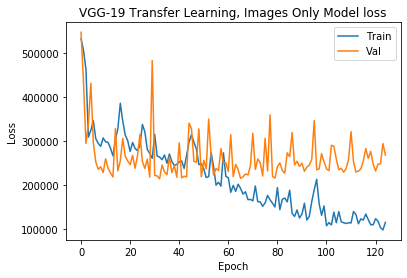

In [151]:
plot_model(transfer, 'VGG-19 Transfer Learning, Images Only')